In [1]:
import re
import math
import importlib 

import spacy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

## 1 使用 Spacy 构建分词器

In [2]:
class Tokenize(object):
    
    def __init__(self, lang):
        self.nlp = importlib.import_module(lang).load()
            
    def tokenizer(self, sentence):
        sentence = re.sub(
        r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(sentence))
        sentence = re.sub(r"[ ]+", " ", sentence)
        sentence = re.sub(r"\!+", "!", sentence)
        sentence = re.sub(r"\,+", ",", sentence)
        sentence = re.sub(r"\?+", "?", sentence)
        sentence = sentence.lower()
        return [tok.text for tok in self.nlp.tokenizer(sentence) if tok.text != " "]

In [3]:
tokenize = Tokenize('zh_core_web_sm')
tokenize.tokenizer('你好，这里是中国。')

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Public\Documents\Wondershare\CreatorTemp\jieba.cache
Loading model cost 0.705 seconds.
Prefix dict has been built successfully.


['你好', '，', '这里', '是', '中国', '。']

## 2 Input Embedding
把输入embedding

### 2.1 token embedding

In [4]:
# 使用了torc.nn.embedding
class Embedding(nn.Module):
    def __init__(self, vocab_size, d_model): # d_model : embedding_dim
        super().__init__()
        self.d_model = d_model
        self.embed = nn.Embedding(vocab_size, d_model)
    # x: [batch_size, max_len]
    def forward(self, x):
        return self.embed(x) * math.sqrt(self.d_model) # [bath_size, max_len, embed_dim]

In [5]:
emb = Embedding(10, 4) # 10个词，每个词有4个维度
x = torch.tensor([[1,3,4,5], [4,1,6,9]])
x_emb = emb(x)
x_emb

tensor([[[-3.1010,  3.0988, -1.3545,  3.3511],
         [-1.5784,  1.3254, -0.2466, -0.5483],
         [-3.8037, -1.0925, -2.0817, -4.5298],
         [-0.2510,  0.9893, -0.8365, -0.8189]],

        [[-3.8037, -1.0925, -2.0817, -4.5298],
         [-3.1010,  3.0988, -1.3545,  3.3511],
         [ 0.2816,  1.5528, -0.7460, -3.6551],
         [ 0.3563,  1.8566,  1.4065, -2.0100]]], grad_fn=<MulBackward0>)

### 2.2 Positional Encoder

In [6]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len=80):
        super(PositionalEncoder, self).__init__()
        self.d_model = d_model
        
        # 创建常量pe矩阵
        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / 10000 ** ((2 * i) / d_model))
                pe[pos, i+1] = math.cos(pos / 10000 ** ((2 * (i + 1)) / d_model))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    # x : [bath_size, max_len, embed_dim]
    def forward(self, x):
        # x相对大一点
        x = x * math.sqrt(self.d_model)
        # x加上positional embedding
        seq_len = x.size(1)
        x += Variable(self.pe[:, :, :seq_len], requires_grad=False) #  .cuda()
        return x

In [7]:
pe = PositionalEncoder(d_model=4, max_seq_len=4)
x_emb_pe = pe(x_emb)
x_emb_pe

tensor([[[-6.2020,  7.1975, -2.7089,  7.7023],
         [-2.3154,  3.6507, -0.4932, -0.0966],
         [-6.6980, -1.1852, -4.1632, -8.0596],
         [-0.3609,  2.9782, -1.6727, -0.6378]],

        [[-7.6073, -1.1850, -4.1634, -8.0596],
         [-5.3605,  7.1975, -2.7088,  7.7023],
         [ 1.4726,  4.1054, -1.4917, -6.3103],
         [ 0.8537,  4.7128,  2.8133, -3.0201]]], grad_fn=<AddBackward0>)

## 3. Transformer Block
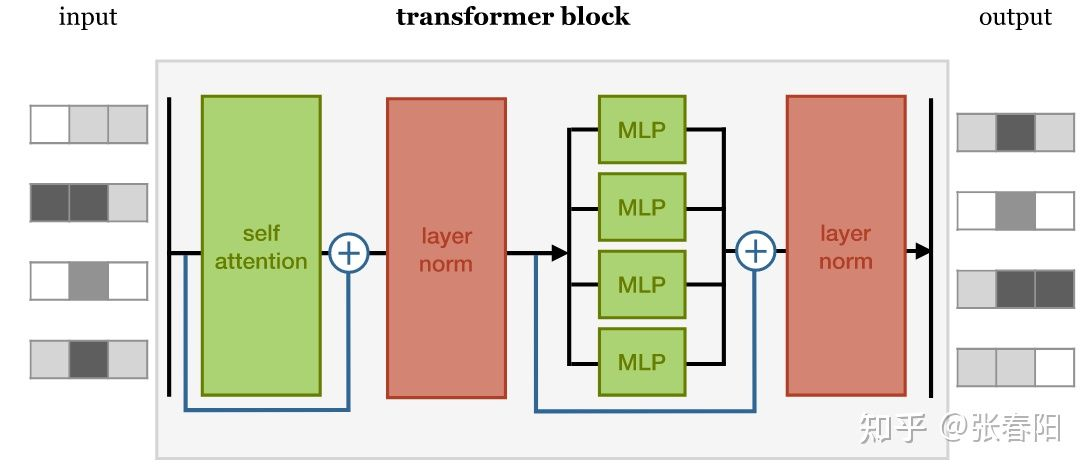

### 3.1 Attention

In [8]:
def attention(q, k, v, d_k, mask=None, dropout=None):
    score = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
    
    #  mask 机制，在 Transformer 中有 attention、encoder 和 decoder 中，有不同的应用
    if mask is not None:
        score = score.masked_fill(mask == 0, -1e9)
        
    softmax = F.softmax(score[-1])
    
    if dropout is not None:
        softmax = dropout(softmax)
    
    output = torch.matmul(softmax, v)
    return output

### 3.2 MultiHeadAttention
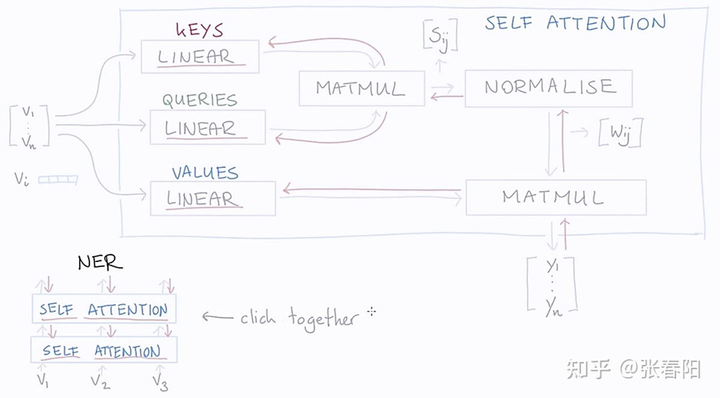

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)
    def forward(self, q, k, v, mask=None):
        bs = q.size(0) #  batch_size
        
        # [batch_size, seq_len, d_model] -> [batch_size, seq_len, heads, d_k], -1 是因为整除的关系
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        k = self.q_linear(k).view(bs, -1, self.h, self.d_k)
        v = self.q_linear(v).view(bs, -1, self.h, self.d_k)
        
        # [batch_size, seq_len, heads, d_k] -> [batch_size, heads, seq_len, d_k] 
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        
        # q=[batch_size, heads, seq_len, d_k] -> score = [batch_size, heads, seq_len, seq_len] -> out=[batch_size, heads, seq_len, d_k]  
        output = attention(q, k, v, self.d_k, mask, self.dropout)
        
        # [batch_size, heads, seq_len, d_k] -> [batch_size, seq_len, heads, d_k] -> [batch_size, seq_len, d_model]
        concat = output.transpose(1, 2).contiguous().view(bs, -1, self.d_model)
        
        output = self.out(concat)
        
        return output

MultiHeadAttention的本质是不进行`[seq_len, d_model]`的计算，而是分成heads个`[seq_len, d_k]`进行计算，最后再concat

In [14]:
mha = MultiHeadAttention(d_model=4, heads=2)
x_multiHead = mha(x_emb_pe, x_emb_pe, x_emb_pe, mask=None)
x_multiHead

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


tensor([[[-5.4360, -2.3776,  3.6263, -2.7104],
         [-7.1273, -0.2746,  9.2300, -1.6651],
         [-6.9396, -0.2905,  9.0184, -1.5745],
         [-6.4316, -0.2915,  8.5307, -1.2751]],

        [[-1.7101,  0.8232,  5.2372,  3.3571],
         [-5.6932,  0.1325,  7.3604, -0.4834],
         [-5.6440,  0.2715,  7.4320, -0.6075],
         [-5.4750,  0.4574,  7.3491, -0.8703]]], grad_fn=<AddBackward0>)

### 3.3  Layer Norm
Layer Norm是对一个句子normalize。Batch Norm是对每个句子的对应索引做normalize。使用 Layer Norm 来使得梯度更加的平稳

In [ ]:
class NormLayer(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super().__init__()
        self.d_model = d_model
        
        self.alpha = nn.Parameter(torch.ones(d_model))
        self.bias = nn.Parameter(torch.zeros(d_model))
        
        self.eps = eps
    
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim= -1, keepdim=True)) / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

In [25]:
# add + norm
norm = NormLayer(4)
x_add_norm = x_emb_pe + norm(x_multiHead)
x_add_norm

tensor([[[-7.1733,  7.0266, -1.3086,  7.4442],
         [-3.3691,  3.6043,  0.8576, -0.3473],
         [-7.7521, -1.2370, -2.8119, -8.3050],
         [-1.4176,  2.9098, -0.3209, -0.8645]],

        [[-8.8097, -1.5498, -3.0691, -7.5868],
         [-6.4827,  7.1608, -1.3987,  7.5509],
         [ 0.3572,  4.0885, -0.1791, -6.4905],
         [-0.2473,  4.7301,  4.1299, -3.2530]]], grad_fn=<AddBackward0>)

### 3.4 Feed Forward Layer

In [27]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.doop = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)
        
    def forward(self, x):
        x = self.dropout(self.linear_1(x))
        x = self.linear_2(x)
        return x

## 4 Encoder
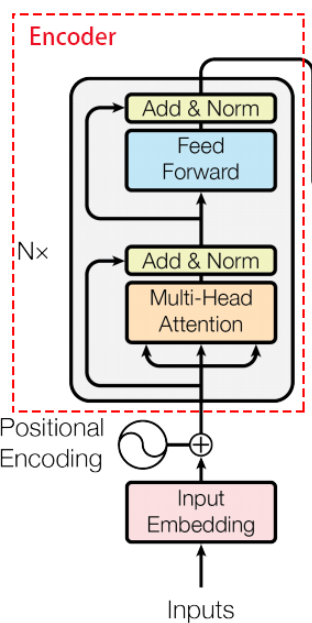

In [34]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1, eps=1e-6):
        super().__init__()
        self.multi_head_attention = MultiHeadAttention(d_model, heads, dropout)
        self.norm = NormLayer(d_model, eps)
        self.FFN = FeedForward(d_model, dropout)
        
    def forward(self, x, mask=None):
        x1 = self.multi_head_attention(x, x, x, mask)
        x2 = self.norm(x1) + x
        x3 = self.FFN(x2)
        out = self.norm(x3) + x2
        return out

In [35]:
def get_clones(model, N):
    return nn.ModuleList([copy.deepcopy(model) for i in range(N)])

class Encoder(nn.Module):
    '''
    N是encoder layer的个数
    '''
    def __init__(self, vocab_size, d_model, N, heads, dropout=0.1, eps=1e-6):
        super().__init__()
        self.N = N
        self.emb = Embedding(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, max_seq_len=80)
        self.layers = get_clones(EncoderLayer(d_model, heads, dropout, eps), N)
    
    def forward(self, src, mask=None):
        x = self.emb(src)
        x = self.pe(x)
        for i in range(N):
            x = self.layers[i](x, mask)
        return x

## 5 Decoder
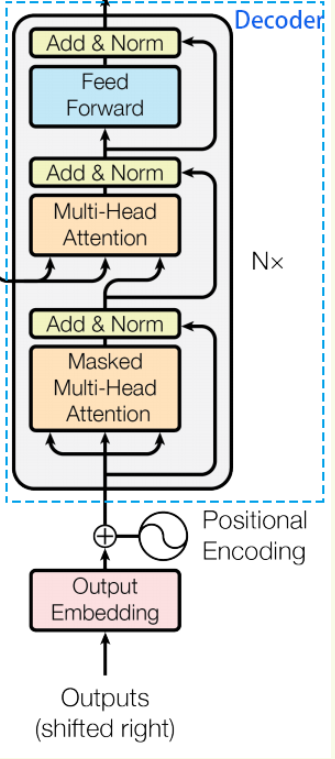

In [36]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, droput=0.1, eps=1e-6):
        super().__init__()
        self.multi_head_attention = MultiHeadAttention(d_model, heads, dropout)
        self.norm = NormLayer(d_model, eps)
        self.FFN = FeedForward(d_model, dropout)
        
    def forward(self, trg, encoder_output, src_mask, trg_mask):
        '''
        trg: encoder的输入
        encoder_output: encoder的输出，在encoder第二个MultiHeadAttention要当作q、k的输入
        scr_mask: encoder第二个MultiHeadAttention的mask
        trg_mask: encoder第一个MultiHeadAttention的mask,做生成任务时一般用到
        '''
        x = self.multi_head_attention(trg, trg, trg, trg_mask)
        x1 = self.norm(x) + trg
        x2 = self.multi_head_attention(encoder_output, encoder_output, x1, src_mask)
        x3 = self.norm(x2) + x1
        out = self.FFN(x3) + x3
        return out

In [37]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, dropout=0.1, eps=1e-6):
        super().__init__()
        self.N = N
        self.emb = Embedding(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, max_seq_len=80)
        self.layers = get_clones(DecoderLayer(d_model, heads, dropout, eps))
        
    def forward(self, trg, e_out, src_mask, trg_mask):
        x = self.emb(trg)
        x = self.pe(x)
        for i in range(N):
            x = self.layers[i](x, e_out, src_mask, trg_mask)
        return x

## 6 Transformer
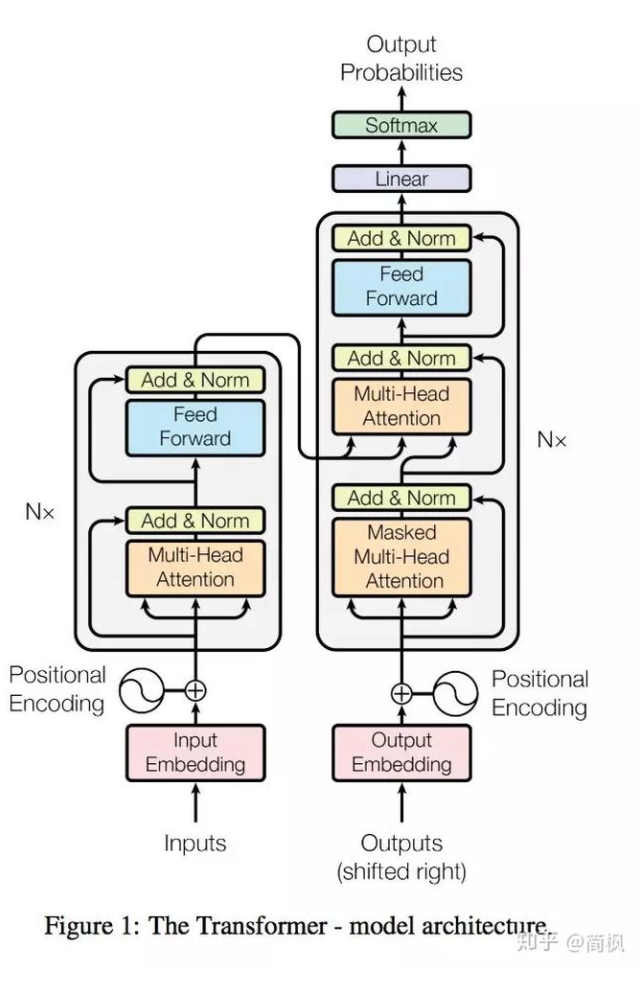

In [39]:
class Transformer(nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads, dropout=0.1, eps=1e-6):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads, dropout, eps)
        self.decoder = Decoder(trg_vocab, d_model, N, heads, dropout, eps)
        
        # d_model需要转换成trg_vocab大小的，因为找到在trg_vocab中最大概率的索引就找到在字典中的那个词了
        self.out = nn.Linear(d_model, trg_vocab)
        
    def forward(self, src, trg, src_mask, trg_mask):
        e_out = self.encoder(src)
        out = self.decoder(trg, e_out, src_mask, trg_mask)
        out = self.out(out)
        return out